In [34]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn import tree, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
#pd.options.display.max_columns = None
df = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
df = df[['FireDiscoveryDateTime','POOState','FireCauseGeneral','DiscoveryAcres','InitialLatitude','InitialLongitude']]

In [3]:
df['YEAR'] = pd.to_datetime(df['FireDiscoveryDateTime']).dt.year
df['DATE'] = pd.to_datetime(df['FireDiscoveryDateTime']).dt.date

df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
#df['DAY_OF_WEEK'] = pd.to_datetime(df['irwin_FireDiscoveryDateTime']).dt.day_of_week
df.FireCauseGeneral.unique()

array(['Equipment', nan, 'Incendiary', 'Lightning', 'Debris/Open Burning',
       'Camping', 'Investigated but Undetermined', 'Other Human Cause',
       'Misc/Other', 'Cause and Origin Not Identified',
       'Firearms/Weapons', 'Other Natural Cause', 'Natural', 'Utilities',
       'Smoking', 'Debris Burning (Fire Use)', 'Coal Seam', 'Railroad',
       'Undetermined'], dtype=object)

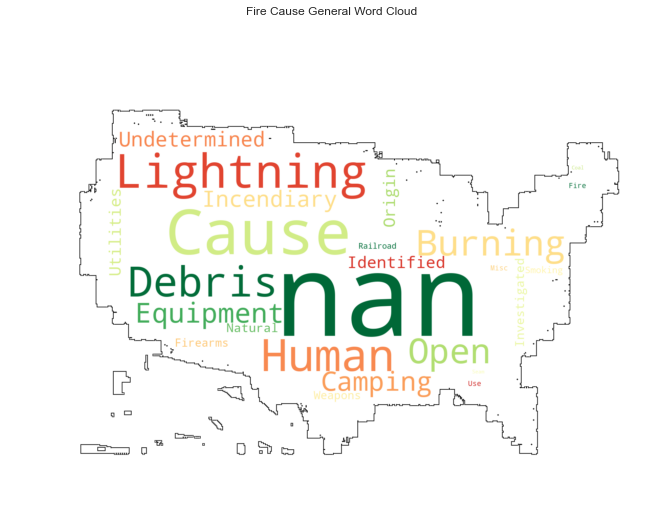

In [4]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Creating the text variable

text = " ".join(review for review in df.FireCauseGeneral.astype(str))

mask = np.array(Image.open("/Users/joisejia/Documents/GU/map of the united states.png"))

# Creating word_cloud with text as argument in .generate() method

word_cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='RdYlGn',
                      mask=mask,
                      background_color='white',
                      stopwords=STOPWORDS,
                      collocations=False,
                      contour_color='black',
                      contour_width=1).generate(str(text))

# Display the generated Word Cloud

plt.figure(figsize=(16,9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fire Cause General Word Cloud")
plt.show()

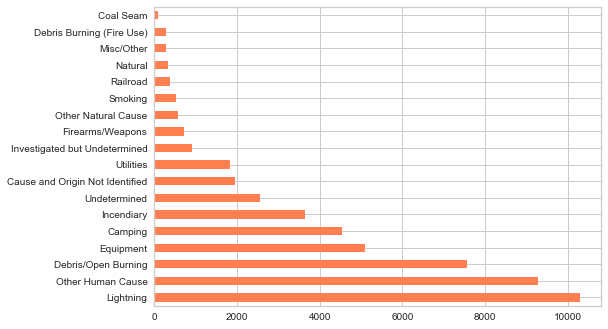

In [5]:
df['FireCauseGeneral'].value_counts().plot(kind='barh',color='coral', alpha=1)
plt.show()

comments: we have 18 different reasons for fires starting. To increase our chances of success we can maybe combine these into a few broader groups. So we will convert the strings into numbers, for example natural = 1, malicious = 2 …

In [6]:
def set_label(cat):
    cause = 0
    natural = ['Lightning','Other Natural Cause', 'Nature']
    accidental = ['Other Human Cause','Debris/Open Burning','Equipment','Camping','Utilities','Firearms/Weapons',
                  'Investigated but Undetermined','Cause and Origin Not Identified','Coal Seam','Railroad','Smoking',
                  'Debris/Open burning']
    malicious = ['Incendiary']
    other = ['Undetermined','Misc/Other']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
df['FireCauseGeneral'] = df['FireCauseGeneral'].apply(lambda x: set_label(x))
df

,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,YEAR,DATE,MONTH
0,2020/08/06 18:58:00+00,US-MT,2,20.0,45.784960,-104.495800,2020,2020-08-06,8
1,2020/02/28 20:45:40+00,US-CA,4,0.1,33.808980,-118.180700,2020,2020-02-28,2
2,2017/10/17 20:20:24+00,US-MT,4,50.0,48.071670,-114.830300,2017,2017-10-17,10
3,2019/07/01 19:54:00+00,US-CA,4,NaN,NaN,NaN,2019,2019-07-01,7
4,2016/06/20 22:05:59+00,US-CA,4,NaN,NaN,NaN,2016,2016-06-20,6
...,...,...,...,...,...,...,...,...,...
211532,2022/03/14 19:46:52+00,US-CA,4,0.1,38.404329,-120.454859,2022,2022-03-14,3
211533,2022/03/14 18:52:51+00,US-TX,4,30.0,31.189829,-97.951463,2022,2022-03-14,3
211534,2022/03/13 20:15:00+00,US-OK,4,3.4,35.358830,-96.185750,2022,2022-03-13,3
211535,2022/03/14 19:39:15+00,US-TX,4,5.0,33.021967,-94.564750,2022,2022-03-14,3


In [7]:
df = df[df['FireCauseGeneral'] != 4]
df.shape

(47366, 9)

In [8]:
# convert string values to numerical categories
df['POOState'] = df['POOState'].map(lambda x: x.removeprefix("US-"))
df['POOState'] = pd.Categorical(df['POOState'])
df["POOState"] = df["POOState"].cat.codes
df.head()

,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,YEAR,DATE,MONTH
0,2020/08/06 18:58:00+00,25,2,20.0,45.78496,-104.49580,2020,2020-08-06,8
5,2020/11/23 19:17:00+00,24,3,1.0,31.06819,-89.06972,2020,2020-11-23,11
7,2020/08/27 14:06:38+00,25,1,0.1,44.65363,-111.56360,2020,2020-08-27,8
8,2020/08/16 19:06:59+00,40,2,NaN,NaN,NaN,2020,2020-08-16,8
10,2019/03/23 10:30:00+00,7,2,NaN,NaN,NaN,2019,2019-03-23,3


In [9]:
df = df.drop(['FireDiscoveryDateTime','DATE'], axis=1)
df.head()

,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,YEAR,MONTH
0,25,2,20.0,45.78496,-104.49580,2020,8
5,24,3,1.0,31.06819,-89.06972,2020,11
7,25,1,0.1,44.65363,-111.56360,2020,8
8,40,2,NaN,NaN,NaN,2020,8
10,7,2,NaN,NaN,NaN,2019,3


In [10]:
df = df.fillna(0)
df.isna().sum()

POOState            0
FireCauseGeneral    0
DiscoveryAcres      0
InitialLatitude     0
InitialLongitude    0
YEAR                0
MONTH               0
dtype: int64

# Evaluating Classifier

In [11]:
import time 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [12]:
X = df.drop(['FireCauseGeneral'], axis=1).values

y = df['FireCauseGeneral']

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average=None)))
    #print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
    #print("{}: micro avg {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))
    #print("{}: weighted {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='weighted')))
    
# Try them all!

models = [
    SVC(), NuSVC(kernel='rbf',nu=0.01), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

SVC: [0.70573248 0.87494991 0.3022942 ]
NuSVC: [0.50953705 0.61611411 0.26954038]
LinearSVC: [0.93287082 0.95333168 0.66402164]
SGDClassifier: [0.79788794 0.89830049 0.21100262]
KNeighborsClassifier: [0.69453436 0.86453783 0.37804421]
LogisticRegression: [0.90686845 0.93788874 0.40729614]
LogisticRegressionCV: [0.         0.81915636 0.        ]
BaggingClassifier: [0.89683056 0.94189848 0.66813113]
ExtraTreesClassifier: [0.94168323 0.96133841 0.73950678]
RandomForestClassifier: [0.94172361 0.96109508 0.73952342]


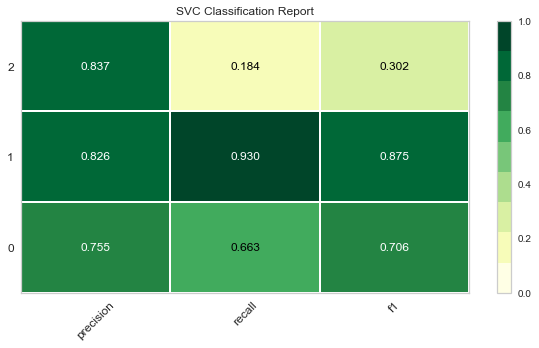

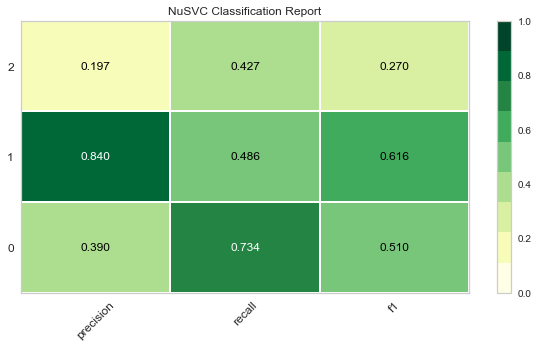

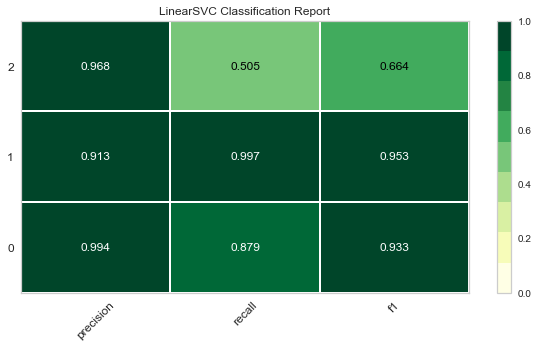

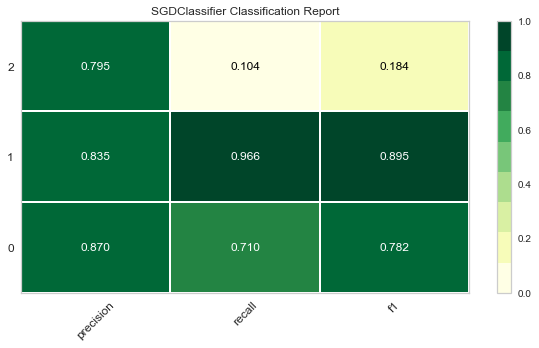

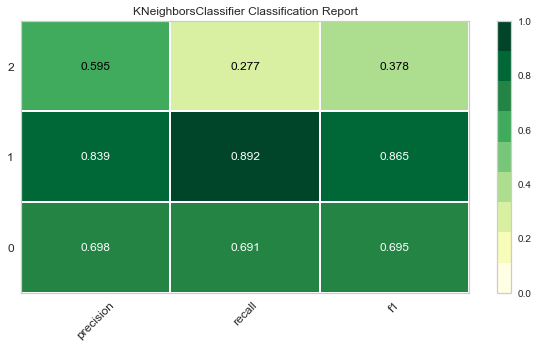

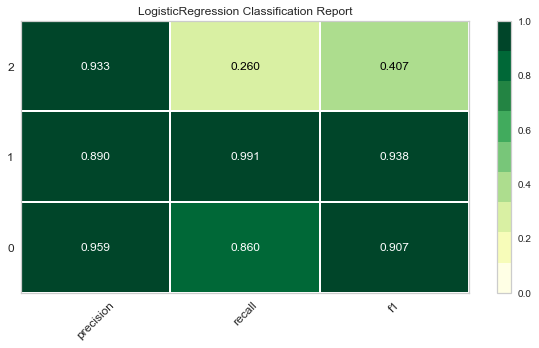

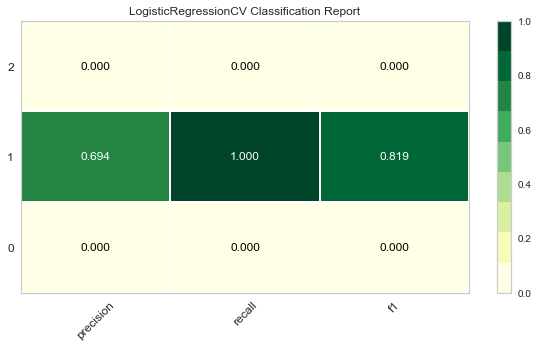

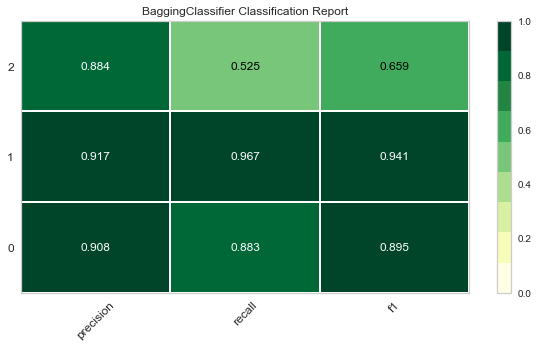

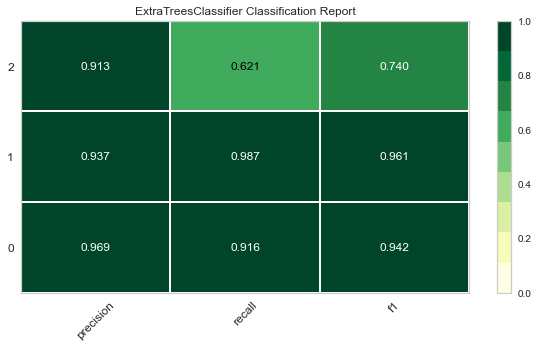

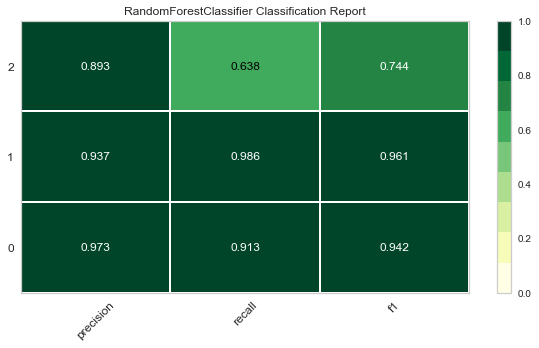

In [13]:
# Classification Report

from yellowbrick.classifier import ClassificationReport

def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=None,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)

In [14]:
X = df.drop(['FireCauseGeneral'], axis=1).values

y = df['FireCauseGeneral']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

def fit_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start 
    score = model.score(X_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    print(model.get_params())

In [15]:
models = (
    LogisticRegression(), 
    SVC(),
    LinearSVC(), 
    RandomForestClassifier(),
    SGDClassifier(max_iter=100, tol=1e-3),
    AdaBoostClassifier(),
    Perceptron(), 
    KNeighborsClassifier(),
    LogisticRegressionCV(cv=3),
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    MLPClassifier(), 
    #MultinomialNB(alpha=0.01) contain negative valuse, can't be used
)

for model in models:
    fit_model(model)
    print()

LogisticRegression fit in 0.78 seconds score: 0.6891
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

SVC fit in 415.24 seconds score: 0.6952
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

LinearSVC fit in 3.85 seconds score: 0.6954
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

RandomForestClassifier fit in 2.52 seconds score: 0.8145
{'bootstrap': True,

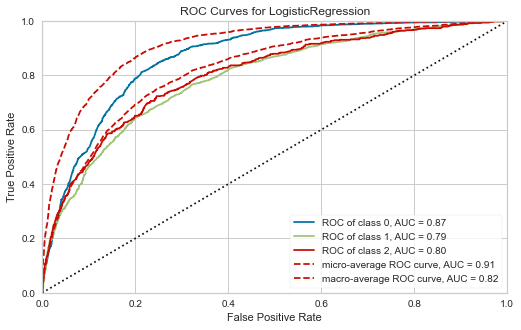

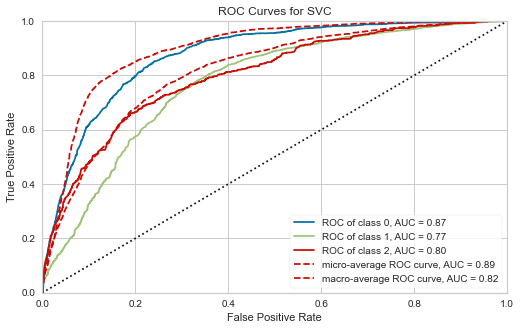

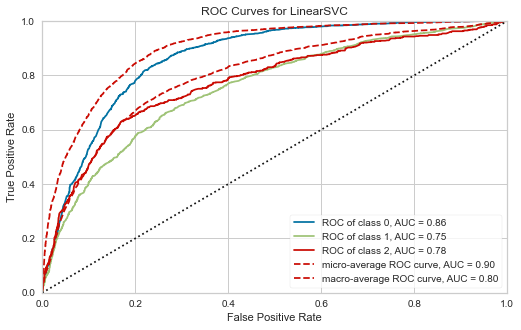

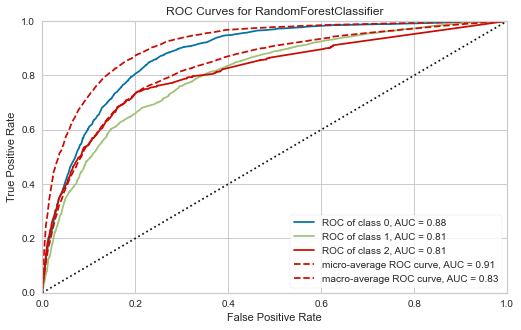

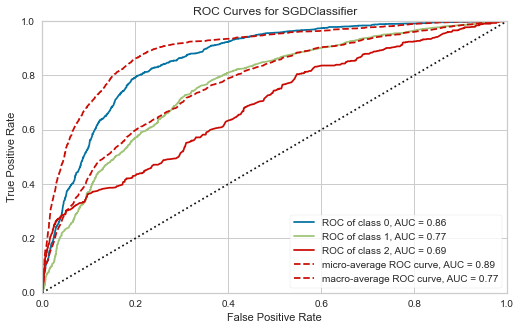

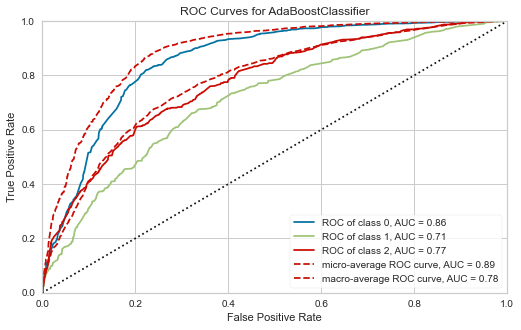

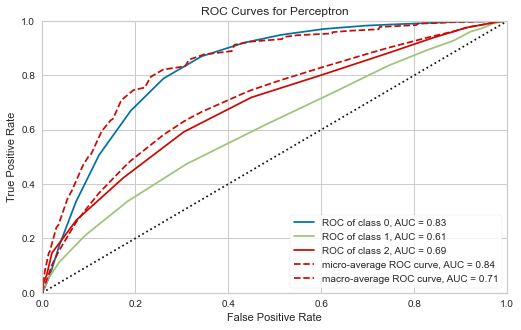

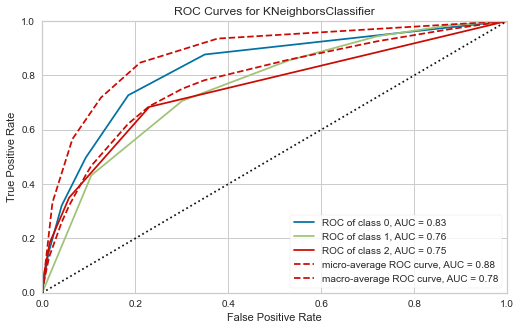

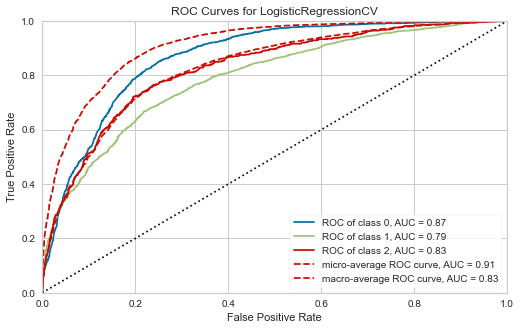

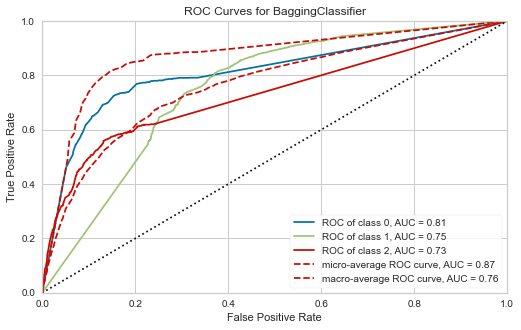

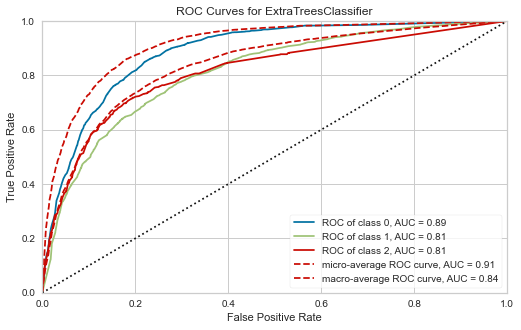

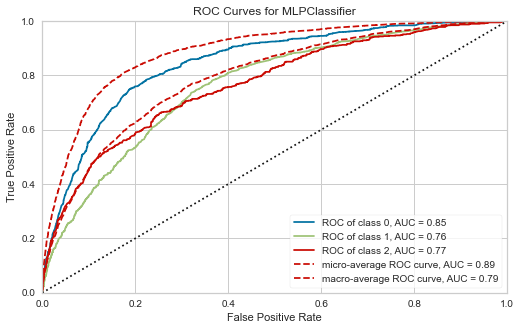

In [16]:
# ROCAUC model visualization

from yellowbrick.classifier import ROCAUC

def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore')),
        ('estimator', estimator),
    ])
    
    # Create the train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    # Instantiate the classification model and visualizer
    visualizer = ROCAUC(
        model, classes=None,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
for model in models:
    visualize_model(X, y, model)


# Evaluating Regressor

In [17]:
# Random Forest Classifier

X = df.drop(['FireCauseGeneral'], axis=1)
y = df['FireCauseGeneral']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=40)
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.8165505594257969


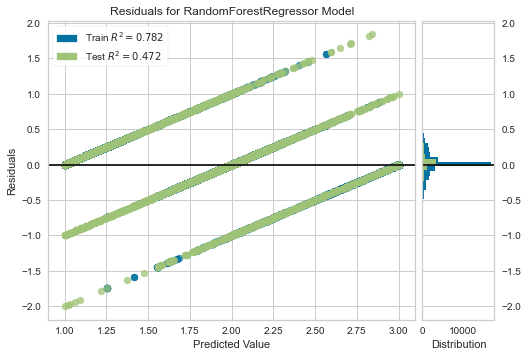

In [18]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
oz = ResidualsPlot(model)

oz.fit(X_train, y_train)
oz.score(X_test, y_test)
_ = oz.show()

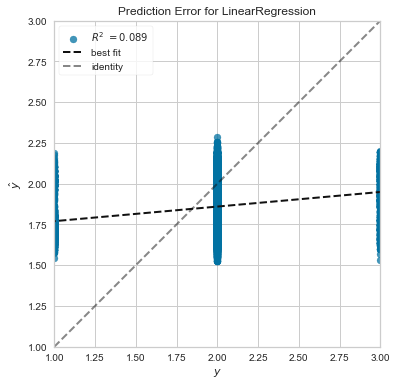

In [19]:
# Linear Regression

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

_, ax = plt.subplots(figsize=(9,6))
_ = prediction_error(model, X_test, y_test, is_fitted=True, ax=ax)

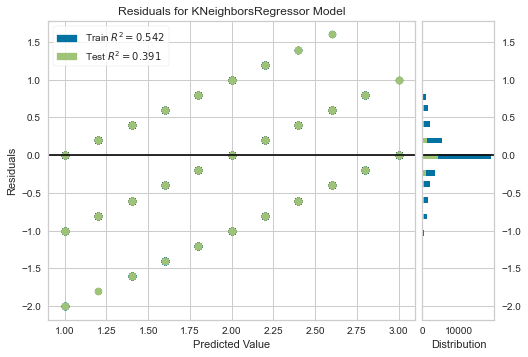

In [20]:
# KNN Regressor

from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
oz = ResidualsPlot(model)

oz.fit(X_train, y_train)
oz.score(X_test, y_test)
_ = oz.show()

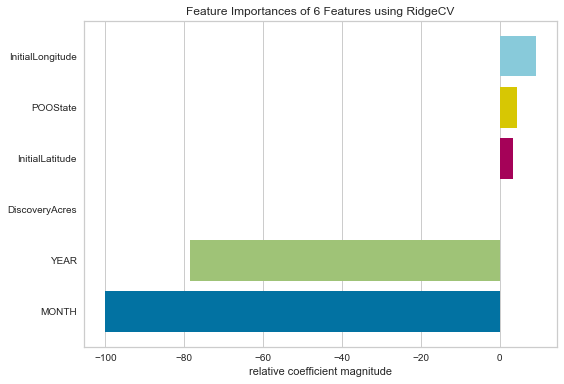

In [21]:
# Ridge Regression

from sklearn.linear_model import RidgeCV
from yellowbrick.features import feature_importances
import numpy as np

model = RidgeCV(alphas=np.logspace(-2, 10, 100))
model.fit(X, y)

_ = feature_importances(model, X, y)

In [22]:
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
#from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

X = df.drop(['FireCauseGeneral'], axis=1).values
y = df['FireCauseGeneral'].values

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.9

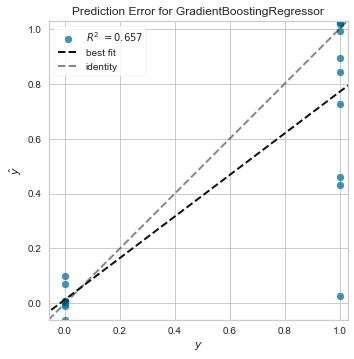

<AxesSubplot:title={'center':'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [23]:
from yellowbrick.regressor import PredictionError

oz = PredictionError(GradientBoostingRegressor())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

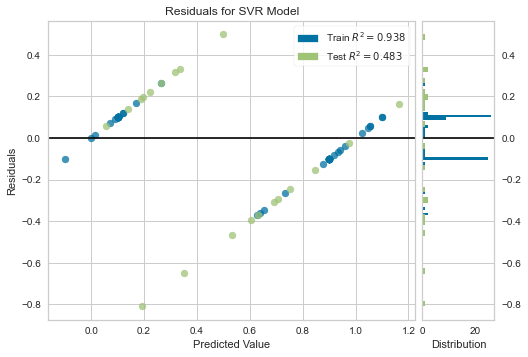

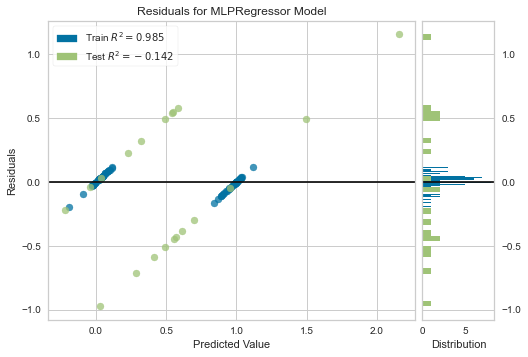

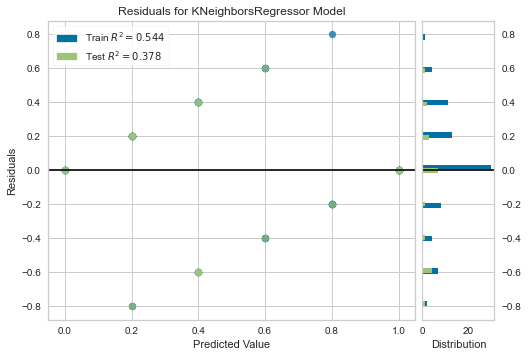

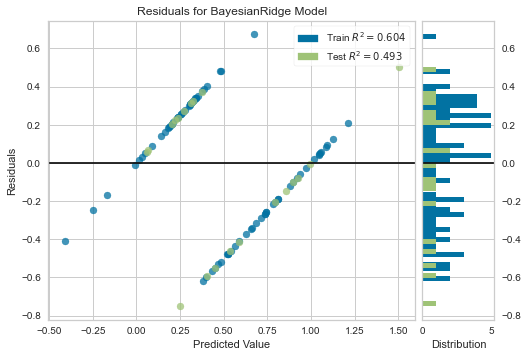

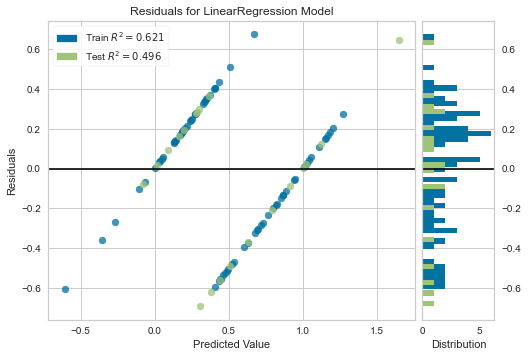

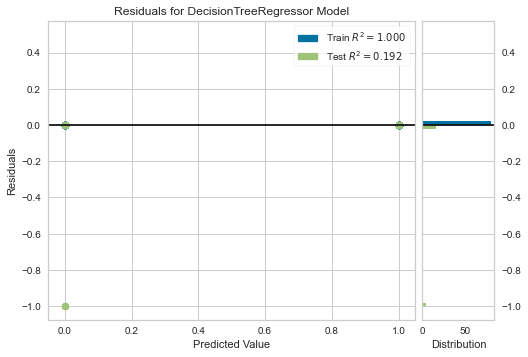

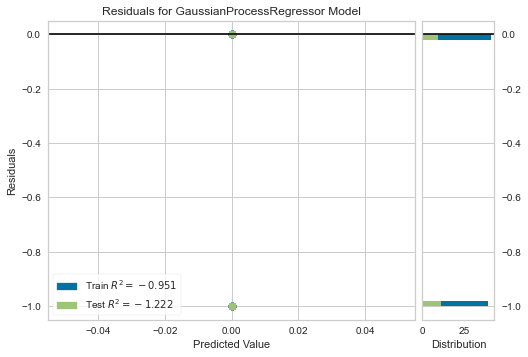

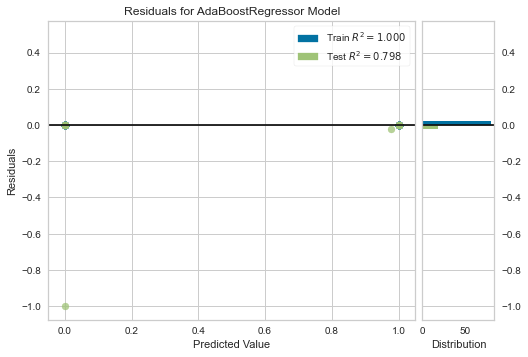

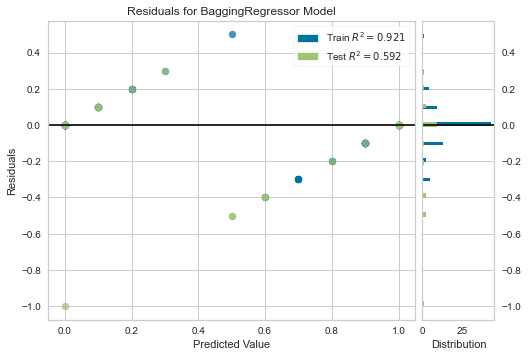

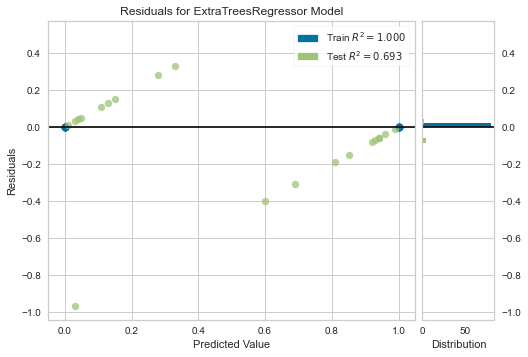

In [24]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor

regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "decision tree": DecisionTreeRegressor(),
    "gaussian process": GaussianProcessRegressor(),
    "ada boost": AdaBoostRegressor(),
    "bagging": BaggingRegressor(),
    "extra tree": ExtraTreesRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

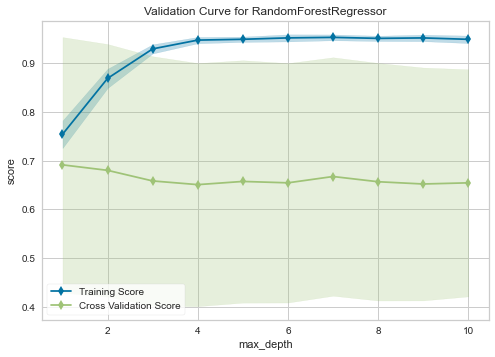

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='max_depth', ylabel='score'>

In [25]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestRegressor(), param_name="max_depth", 
    param_range=np.arange(1, 11), cv=10, scoring="r2")

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

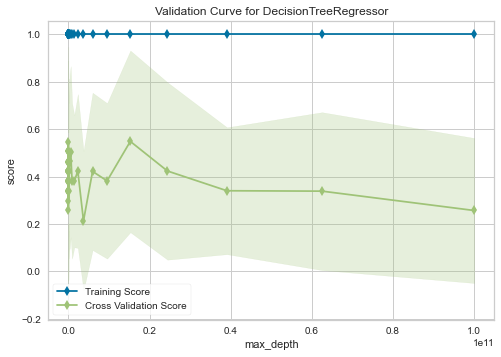

<AxesSubplot:title={'center':'Validation Curve for DecisionTreeRegressor'}, xlabel='max_depth', ylabel='score'>

In [26]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth", 
    param_range=np.logspace(1,11), cv=10, scoring="r2")

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

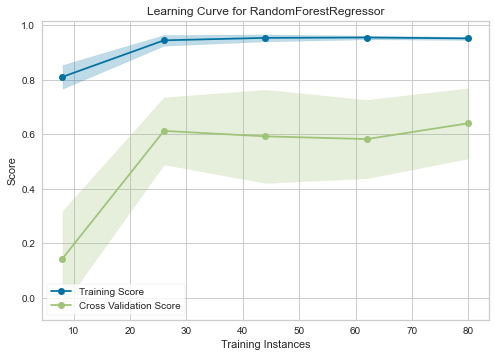

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [27]:
from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer

model = RandomForestRegressor()
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


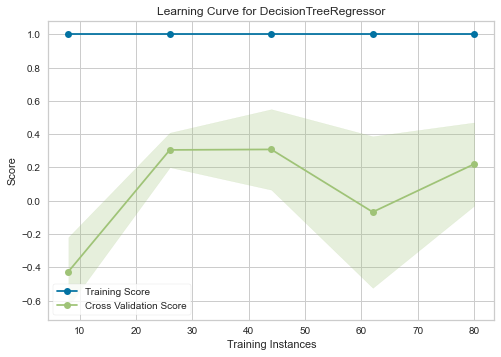

<AxesSubplot:title={'center':'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [28]:
model = DecisionTreeRegressor()
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

